In [1]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt

from to
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms

In [2]:
num_workers = 0
batch_size = 64

transform = transforms.ToTensor()

In [3]:
fsmnist_train_data = FashionMNIST(root='data', train=True, download=True, transform=transform)
fsmnist_train_loader = torch.utils.data.DataLoader(fsmnist_train_data, num_workers=num_workers, batch_size=batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



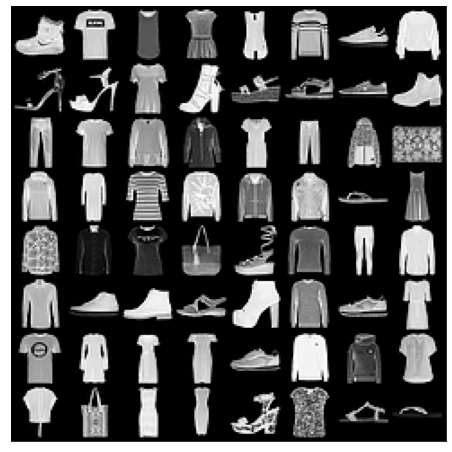

In [6]:
import torchvision

#show vài ảnh của dữ liệu fashionMNIST
dataiter = iter(fsmnist_train_loader)
images, labels = dataiter.next()

images = torchvision.utils.make_grid(images)

numpy_imgs = images.numpy()

plt.figure(figsize=(8,8))
plt.imshow(np.transpose(numpy_imgs, (1,2,0)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [8]:
import torch.nn as nn

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # xác định các layer ẩn
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, output_size),
        )
        
    def forward(self, input):
        input = input.view(-1, 28*28)
        out = self.model(input)

        return out

In [9]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, hidden_dim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*2, hidden_dim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim*4, output_size),
        )

    def forward(self, input):
        # apply tanh
        out = torch.tanh(self.model(input))

        return out

In [10]:
# Tham số mạng Discriminator

# ảnh đầu vào 28*28
input_size = 784
# kích thước đầu ra mạng Discriminator
d_output_size = 1
# kích thước layer ẩn cuối cùng
d_hidden_size = 32

# Tham số mạng Generator

# Kích thước vector nhiễu đưa vào Generator
z_size = 100
# Kích thước ảnh đẩu ra (generated image)
g_output_size = 784
# Kích thước layer ẩn cuối
g_hidden_size = 32

In [11]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

#print(D)
#print(G)

In [12]:
# Tính toán mất mát
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    
    if smooth:
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) 
        
    # Tính real loss với hàm Sigmoid và BCE
    criterion = nn.BCEWithLogitsLoss()
  
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    
    labels = torch.zeros(batch_size) 
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [13]:
# Tối ưu
import torch.optim as optim
import pickle as pkl

learing_rate = 1e-3

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), learing_rate)
g_optimizer = optim.Adam(G.parameters(), learing_rate)

In [15]:
# Epochs training
num_epochs = 100

# Lưu lại kết quả của hàm mất mát và các mẫu sinh
samples = []
losses = []

print_every = 400

# vector nhiều
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Training
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(fsmnist_train_loader):
                
        batch_size = real_images.size(0)
        
        ## Rescale ảnh cho Leaky ReLU
        real_images = real_images*2 - 1  #[0,1) thành [-1, 1)
        
        # ============================================
        #            Huấn luyện cho DISCRIMINATOR
        # ============================================
        
        # set d_optimizer = 0 chuẩn bị cho lan truyền ngược
        d_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh thực

        # Tính mất mát của discriminator với ảnh thực 
        # smooth nhãn thực
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Huấn luyện với ảnh giả
        
        # Sinh ảnh giả
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Tính mất mát của discriminator với ảnh giả     
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # Cộng kết quả 2 loss, tối ưu và cập nhật hệ số
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            Huấn luyện GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh sinh vầ nhãn ngược
        
        # Tạo ảnh giả
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Tính mất mát của discriminator trên ảnh giả nhưng sử dụng label ngược
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # sử  dụng real_loss cho label ngược
        
        # Lan truyền ngược, tối ưu, cập nhật
        g_loss.backward()
        g_optimizer.step()

        # Print số liệu mất mát
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## Sau mỗi epoch
    # bổ sung discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # tạo và lưu mẫu sinh
    G.eval() # eval mode
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # train lại mô hình


# Lưu lại tất cả các mẫu đã sinh
with open('fs_train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 1.3958 | g_loss: 0.6806
Epoch [    1/  100] | d_loss: 0.5903 | g_loss: 5.1996
Epoch [    1/  100] | d_loss: 0.4687 | g_loss: 3.6489
Epoch [    2/  100] | d_loss: 0.4672 | g_loss: 4.2268
Epoch [    2/  100] | d_loss: 1.0778 | g_loss: 3.4539
Epoch [    2/  100] | d_loss: 0.7134 | g_loss: 2.9172
Epoch [    3/  100] | d_loss: 0.6688 | g_loss: 3.4662
Epoch [    3/  100] | d_loss: 0.8100 | g_loss: 3.0730
Epoch [    3/  100] | d_loss: 0.8912 | g_loss: 2.6681
Epoch [    4/  100] | d_loss: 0.7299 | g_loss: 3.1036
Epoch [    4/  100] | d_loss: 0.9248 | g_loss: 2.2349
Epoch [    4/  100] | d_loss: 1.1246 | g_loss: 1.4229
Epoch [    5/  100] | d_loss: 1.0730 | g_loss: 1.5541
Epoch [    5/  100] | d_loss: 0.9417 | g_loss: 1.9003
Epoch [    5/  100] | d_loss: 1.0783 | g_loss: 1.5589
Epoch [    6/  100] | d_loss: 1.2484 | g_loss: 1.5343
Epoch [    6/  100] | d_loss: 1.3328 | g_loss: 1.8197
Epoch [    6/  100] | d_loss: 1.1362 | g_loss: 1.5954
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.2516 | g_loss: 0.9255
Epoch [   52/  100] | d_loss: 1.3084 | g_loss: 0.9188
Epoch [   52/  100] | d_loss: 1.3076 | g_loss: 1.0487
Epoch [   52/  100] | d_loss: 1.2788 | g_loss: 1.1260
Epoch [   53/  100] | d_loss: 1.2313 | g_loss: 1.1050
Epoch [   53/  100] | d_loss: 1.2759 | g_loss: 0.9169
Epoch [   53/  100] | d_loss: 1.2060 | g_loss: 0.9994
Epoch [   54/  100] | d_loss: 1.2758 | g_loss: 1.0490
Epoch [   54/  100] | d_loss: 1.3176 | g_loss: 0.9586
Epoch [   54/  100] | d_loss: 1.3051 | g_loss: 0.9493
Epoch [   55/  100] | d_loss: 1.3821 | g_loss: 0.9356
Epoch [   55/  100] | d_loss: 1.2234 | g_loss: 0.9356
Epoch [   55/  100] | d_loss: 1.3276 | g_loss: 0.9626
Epoch [   56/  100] | d_loss: 1.3466 | g_loss: 0.9968
Epoch [   56/  100] | d_loss: 1.2771 | g_loss: 1.0824
Epoch [   56/  100] | d_loss: 1.2573 | g_loss: 1.0026
Epoch [   57/  100] | d_loss: 1.2621 | g_loss: 1.0294
Epoch [   57/  100] | d_loss: 1.2728 | g_loss: 0.9569
Epoch [   57/  100] | d_loss

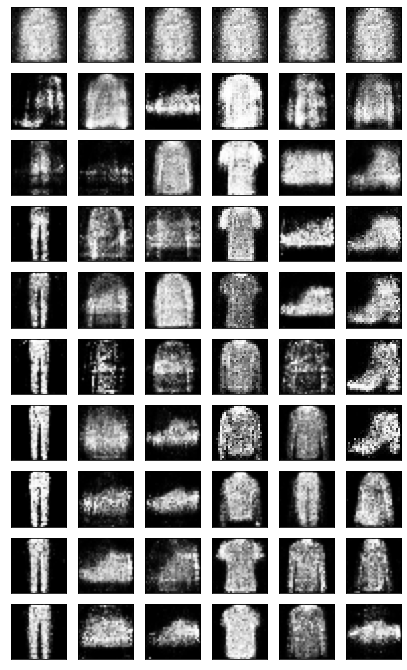

In [16]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

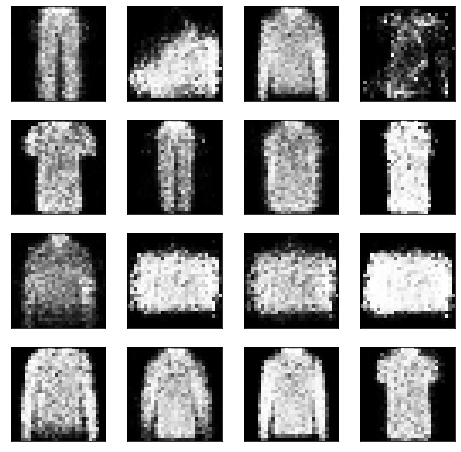

In [17]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(8,8), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Lấy mẫu từ file đã lưu
with open('fs_train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

#xem kết quả sau khi kết thúc training
view_samples(-1, samples)

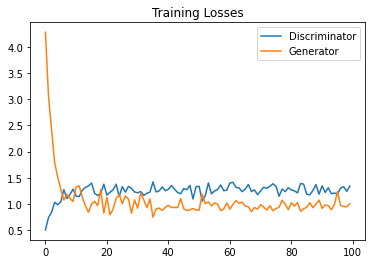

In [18]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

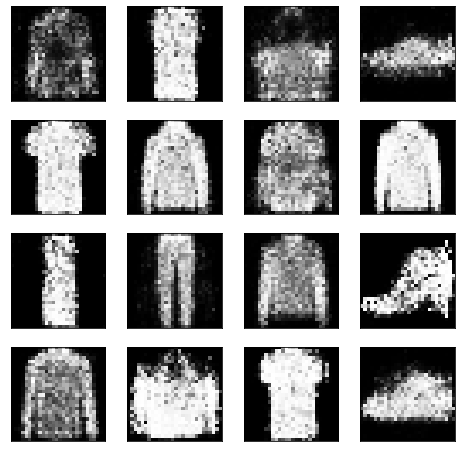

In [19]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval()
rand_images = G(rand_z)

view_samples(0, [rand_images])